# Experiment 8:
## Reconstruction with dithering, CIFAR-10, stronger noise

This experiment shows the behaviour of the regularized reconstruction method with dithering on the CIFAR-10 data set for various  levels of noise using a generative model.

In [1]:
import numpy as np;
import numpy.linalg as linalg;

import matplotlib.pyplot as plt;
from matplotlib.pyplot import figure;

import pywt;

import torch;
import torch.nn as nn;
import torch.nn.functional as F;
import torch.optim as optim;

from torch.utils.data import DataLoader;
import torchvision;
import torchvision.transforms as transforms;

from torch.autograd import Variable

import pickle;
import time;
import random;
import math;

from IPython.display import clear_output;
from PIL import Image

import os

import CIFAR10_utils as CIFAR;
import CIFAR10_generative as generative;
import sparsity_utils as sparsity;
import general_utils as utils;

# Initialization

In [2]:
(train_data, test_data), (train_loader, test_loader) = CIFAR.load_dataset();
sigma = [0.0, 25.0, 50.0];

mspace_gen = [2000, 10000, 20000];
lambda_space = np.linspace(1, 150, 25);

repetitions = 1; #3
img_num = 5;

Files already downloaded and verified
Files already downloaded and verified


In [3]:
utils.reset_seeds();
autoEncoder = generative.createNetwork();
generative.trainNetwork(autoEncoder, train_loader);

projector = lambda x : generative.project(x, autoEncoder , num_epochs = 50, learning_rate = 0.001);

[1,  2000] loss: 0.596
[2,  2000] loss: 0.580
[3,  2000] loss: 0.570
[4,  2000] loss: 0.568
[5,  2000] loss: 0.568
[6,  2000] loss: 0.567
[7,  2000] loss: 0.567
[8,  2000] loss: 0.567
[9,  2000] loss: 0.566
[10,  2000] loss: 0.566


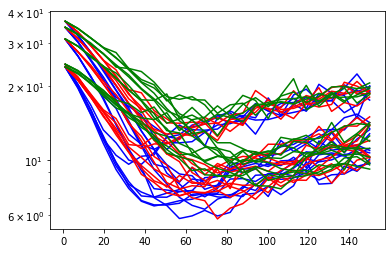

In [4]:
results = [[[len(lambda_space)*[0] for j in range(img_num)] for i in range(len(mspace_gen))] for k in sigma];

utils.reset_seeds();
for s in range(len(sigma)):
    noise = sigma[s];
    for i in range(len(mspace_gen)):
        m = mspace_gen[i];

        for j in range(img_num):
            x_true = CIFAR.getImageAsVector(test_loader, j);

            for k in range(len(lambda_space)):
                lamb = lambda_space[k];

                accum = 0;
                for n in range(repetitions):
                    A = None;
                    A, q = utils.generateMeasurements_Gaussian_dithering(x_true, m, noise, lamb);      
                    x, acc, obj =  CIFAR.reconstruct_regularized_dithering(A, q, lamb, x_true, projector, learning_param = 0.2, iterations = 50);
                    accum += acc;
                results[s][i][j][k] = accum/repetitions;
                print(lamb);

            clear_output(wait=True);
            plt.yscale('log');
            for ss in range(s+1):
                for ii in range(i+1):
                    for jj in range(j+1):
                        col = 'b';
                        if ss == 0:
                            col = 'b';
                        elif ss == 1:
                            col = 'r';
                        else:
                            col = 'g';
                        plt.plot(lambda_space, results[ss][ii][jj], c=col);
            plt.show();

In [8]:
utils.saveData(results, "results_data/cifar_noise.data");

In [3]:
results = utils.loadData("results_data/cifar_noise.data");

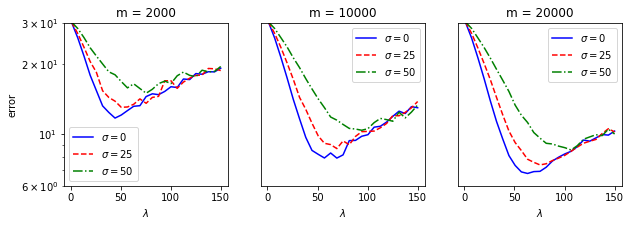

In [4]:
f = plt.figure(figsize=(10,3));
ax1 = f.add_subplot(131);
ax2 = f.add_subplot(132);
ax3 = f.add_subplot(133);


ax1.plot(lambda_space, np.mean(results[0][0], axis=0), 'b');
ax1.plot(lambda_space, np.mean(results[1][0], axis=0), 'r', linestyle='--');
ax1.plot(lambda_space, np.mean(results[2][0], axis=0), 'g', linestyle='-.');

ax1.set_yscale("log");
ax1.legend([r"$\sigma = 0$", r"$\sigma = 25$", r"$\sigma = 50$"]);
ax1.set_xlabel(r"$\lambda$");
ax1.set_ylabel("error");
ax1.set_title("m = 2000");
ax1.set_ylim([6, 30]);



ax2.plot(lambda_space, np.mean(results[0][1], axis=0), 'b');
ax2.plot(lambda_space, np.mean(results[1][1], axis=0), 'r', linestyle='--');
ax2.plot(lambda_space, np.mean(results[2][1], axis=0), 'g', linestyle='-.');

ax2.set_yscale("log");
ax2.legend([r"$\sigma = 0$", r"$\sigma = 25$", r"$\sigma = 50$"]);
ax2.set_xlabel(r"$\lambda$");
ax2.set_ylabel("error");
ax2.set_title("m = 10000");
ax2.set_ylim([6, 30]);
ax2.get_yaxis().set_visible(False)


ax3.plot(lambda_space, np.mean(results[0][2], axis=0), 'b');
ax3.plot(lambda_space, np.mean(results[1][2], axis=0), 'r', linestyle='--');
ax3.plot(lambda_space, np.mean(results[2][2], axis=0), 'g', linestyle='-.');

ax3.set_yscale("log");
ax3.legend([r"$\sigma = 0$", r"$\sigma = 25$", r"$\sigma = 50$"]);
ax3.set_xlabel(r"$\lambda$");
ax3.set_ylabel("error");
ax3.set_title("m = 20000");
ax3.set_ylim([6, 30]);
ax3.get_yaxis().set_visible(False)

plt.savefig("results_images/cifar_dithering_noise_lambda.png", dpi=200);